In [2]:
import numpy as np
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers import SetResolution, ToDiscrete
from gym.wrappers import SkipWrapper

from gym import wrappers


# (see https://github.com/ppaquette/gym-doom/blob/master/ppaquette_gym_doom/doom_basic.py)
def create_env(seed=None, monitor_directory=None, force=True, resume=False):
    env_spec = gym.spec('ppaquette/DoomBasic-v0')
    env_spec.id = 'DoomBasic-v0'
    env = env_spec.make()

    if seed is not None:
        env.seed(seed)

    if monitor_directory is not None:
        env = wrappers.Monitor(env, monitor_directory, force=True, resume=resume, mode='training', 
                               video_callable=lambda episode_id: episode_id % 100 == 0)

    return SkipWrapper(repeat_count=4)(
        ToDiscrete('minimal')(env))

NOOP, SHOOT, RIGHT, LEFT = 0, 1, 2, 3

(480, 640, 3)


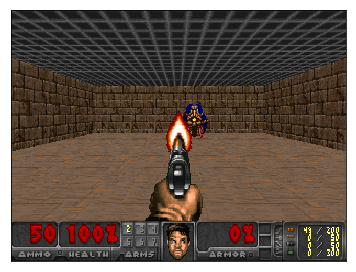

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.transform import resize
from skimage.color import rgb2gray

WIDTH, HEIGHT, CHANNELS = 200, 150, 1


def pre_process(obs, size=(HEIGHT, WIDTH)):
    return resize(rgb2gray(obs), size).reshape((-1,) + size)

env = create_env()
obs = env.reset()
obs, _, _, _ = env.step(action=1)

plt.figure(figsize=[6, 6])

print(obs.shape)
def show(observation):
    if CHANNELS == 1:
        plt.imshow(observation.squeeze(), interpolation=None, cmap='gray')
    else:
        plt.imshow(observation, interpolation=None)
    plt.xticks([]); plt.yticks([]);
    
show(obs)
env.close()

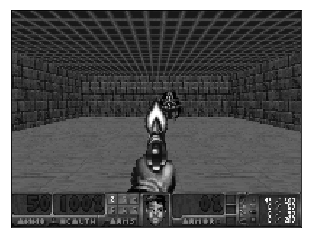

In [5]:
show(pre_process(obs))

## Deep Q-learning

 * https://github.com/coreylynch/async-rl/blob/master/model.py and https://github.com/tflearn/tflearn/blob/master/examples/reinforcement_learning/atari_1step_qlearning.py with 84 x 84 images

```
    net = tflearn.conv_2d(net, 32, 8, strides=4, activation='relu')
    net = tflearn.conv_2d(net, 64, 4, strides=2, activation='relu')
    net = tflearn.fully_connected(net, 256, activation='relu')
```

 * https://github.com/ebonyclock/deep_rl_vizdoom/blob/master/networks/common.py#L20 with 80 x 60 images
 
```
    conv1 = layers.conv2d(img_input, num_outputs=8, kernel_size=[6, 6], stride=3, padding="VALID", ...)
    conv2 = layers.conv2d(conv1, num_outputs=8, kernel_size=[3, 3], stride=2, padding="VALID", ...)

```
 * From http://vizdoom.cs.put.edu.pl/tutorial#learning with images (30, 45)!
```
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[6, 6], nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=3)
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[3, 3],nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=2)
dqn = DenseLayer(dqn, num_units=128, nonlinearity=rectify, W=HeUniform("relu"), b=Constant(.1))
```
 

In [6]:
import tensorflow as tf
from keras import backend as K

from keras.layers import Input, Dense, Convolution2D, Flatten, Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam

sess = tf.InteractiveSession()
K.set_session(sess)

def create_q_model(conv1_weights=None, conv2_weights=None, dense1_weights=None, dense2_weights=None):

    input_image = Input(shape=(CHANNELS, HEIGHT, WIDTH))
    x = Convolution2D(nb_filter=4, nb_row=6, nb_col=6, subsample=(3, 3), border_mode='same', weights=conv1_weights
                     )(input_image)
    x = Activation('relu')(x)
    x = Convolution2D(nb_filter=4, nb_row=3, nb_col=3, subsample=(2, 2),  border_mode='same', weights=conv2_weights
                     )(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(128, init='normal', weights=dense1_weights)(x)
    x = Activation('relu')(x)
    action_values = Dense(4, init='normal', weights=dense2_weights)(x)
    model = Model(input=input_image, output=action_values)
    model.compile(loss='mse', optimizer=Adam())
    
    return model


acting_model = create_q_model()
target_model = create_q_model()

def copy_model(model):
    conv1_weights =  [w.eval() for w in model.layers[1].weights]
    conv2_weights = [w.eval() for w in model.layers[3].weights]
    dense1_weights = [w.eval() for w in model.layers[6].weights]
    dense2_weights = [w.eval() for w in model.layers[8].weights]
    return create_q_model(conv1_weights, conv2_weights, dense1_weights, dense2_weights)

acting_model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 150, 200)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 4, 50, 67)     148         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 4, 50, 67)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 4, 25, 34)     148         activation_1[0][0]               
___________________________________________________________________________________________

## Collecting and preparing experiences for learning

In [7]:
# from https://docs.python.org/3/library/itertools.html#recipes
from itertools import tee, zip_longest

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [8]:
from collections import namedtuple, deque
from itertools import islice 
import operator
import functools
import random


SARE = namedtuple('SAR', ['state', 'action', 'reward', 'end'])
Experience = namedtuple('Experience', ['previous_state', 'action', 'reward', 'next_state', 'end'])


class EpsilonGreedyQAgent(object):
    def __init__(self, model, epsilon=.1):
        self.model = model
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice([NOOP, SHOOT, LEFT, RIGHT])
        else:
            return self.model.predict(observation[np.newaxis])[0].argmax()

def generate_sares(env, agent, episode_count=2000):
    reward = 0
    done = False

    for i in range(episode_count):
        episode_sares = []
        observation = pre_process(env.reset())
        while True:
            action = agent.act(observation, reward, done)
            new_observation, reward, done, _ = env.step(action)
            sare = SARE(observation, action, reward, done)
            episode_sares.append(sare)
            yield sare

            if done:
                if (i % 10) == 0:
                    print('episode {i} with {steps} steps, {reward:.0f} reward and #actions {actions}'.format(
                        i=i, steps=len(episode_sares), reward=sum(sar.reward for sar in episode_sares),
                        actions=np.bincount([sar.action for sar in episode_sares])))
                break
            else:
                observation = pre_process(new_observation)


def to_experiences(sares):
    return (
        Experience(previous_s, a, r, next_s, end) 
        for (previous_s, a, r, end), (next_s, _, _, _) 
        in pairwise(sares)
    )

import itertools as it

class ExperiencesReplay:
    def __init__(self, experiences_iterable, memory_size=1000, batch_size=32, replay_ratio=.25):
        self.experiences_iterable = experiences_iterable
        self.batch_size = batch_size
        self.replay_ratio = replay_ratio
        self.memory = deque(maxlen=memory_size)

    def __iter__(self):
        return self

    def __next__(self):
        new_experiences = list(it.islice(self.experiences_iterable, int(self.replay_ratio * self.batch_size)))
        if len(new_experiences) == 0:
            raise StopIteration()
        
        for exp in new_experiences:
            self.memory.appendleft(exp)
        
        experiences_batch = list(e for e in self.memory if e.reward > 0)[:5] \
            + random.choices(self.memory, k=self.batch_size)
        random.shuffle(experiences_batch)
        return experiences_batch
    
env = create_env()

experiences = to_experiences(generate_sares(env, EpsilonGreedyQAgent(acting_model), episode_count=2))

streamlined_experience_batches = grouper(experiences, n=10)

print('streamlined_experience_batches')
print(len(list(next(streamlined_experience_batches))))

print('replayed_batches')
replayed_batches = ExperiencesReplay(experiences, memory_size=100)

for b in replayed_batches:
    print(len(b), len(replayed_batches.memory))

streamlined_experience_batches
10
replayed_batches
32 8
32 16
32 24
32 32
32 40
32 48
32 56
episode 0 with 70 steps, -370 reward and #actions [ 2  4  0 64]
32 64
32 72
32 80
32 88
32 96
32 100
32 100
32 100
32 100
32 100


## Training

In [9]:
class DeepQNetworkTrainer:
    
    MINI_BATCH_SIZE = 128
    UPDATE_TARGET_EVERY_N_BACTHES = 2
    
    def __init__(self, acting_model, target_model, double_q=False, gamma=.99, reward_clip=5):
        self.acting_model = acting_model
        self.target_model = target_model
        self.double_q = double_q
        
        self.gamma = gamma
        self.reward_clip = reward_clip

        # counter to periodically set target_model <- acting_model
        self.trained_epochs = 0
    
    def fit_episodes(self, experiences_batch):
        prev_frames, target_action_rewards = self._batch_to_input_targets(experiences_batch, double_q=self.double_q)
        self.acting_model.fit(x=prev_frames, y=target_action_rewards, batch_size=self.MINI_BATCH_SIZE, nb_epoch=1, verbose=0)
        self.trained_epochs += 1

        if (self.trained_epochs % self.UPDATE_TARGET_EVERY_N_BACTHES) == 0:
            self.target_model = copy_model(self.acting_model)

    def _batch_to_input_targets(self, experiences_batch, double_q=False):
        
        prev_frames, actions, rewards, next_frames, is_ends = map(np.asarray, zip(*experiences_batch))
        n_samples = len(experiences_batch)
        clipped_rewards = np.clip(rewards, -np.inf, self.reward_clip)

        if double_q:
            greedy_actions = self.acting_model.predict(next_frames).argmax(axis=1)
            actions_target_values = self.target_model.predict(next_frames)[np.arange(n_samples), greedy_actions]            
            targets = clipped_rewards + self.gamma * (1 - is_ends) * actions_target_values
        else:
            # Transcription of the Q-learning target formula
            targets = clipped_rewards + self.gamma * (1 - is_ends) * self.target_model.predict(next_frames).max(axis=1)

        target_action_rewards = self.target_model.predict(prev_frames)
        target_action_rewards[np.arange(n_samples), actions] = targets
        return prev_frames, target_action_rewards
    
trainer = DeepQNetworkTrainer(acting_model, target_model)

In [10]:
import itertools as it

N_EPISODES = 1500

directory = 'tmp/DoomBasic_dqn_resize_rgb'
env = create_env(monitor_directory=directory)

agent = EpsilonGreedyQAgent(acting_model, epsilon=.1)
experiences = to_experiences(generate_sares(env, agent, episode_count=N_EPISODES))
experience_batches = ExperiencesReplay(
    experiences,
    memory_size=1000, batch_size=DeepQNetworkTrainer.MINI_BATCH_SIZE)

for experience_batch in experience_batches:
    trainer.fit_episodes(experience_batch)

# final greedy episodes
sares = list(generate_sares(env, EpsilonGreedyQAgent(acting_model, epsilon=0), episode_count=100))

env.close()
gym.upload(directory, api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-03-13 11:00:54,408] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-13 11:00:54,409] Clearing 5 monitor files from previous run (because force=True was provided)
[2017-03-13 11:00:54,796] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000000.mp4


episode 0 with 70 steps, -415 reward and #actions [ 2 32  6 30]
episode 10 with 66 steps, -341 reward and #actions [ 3 60  3]
episode 20 with 70 steps, -400 reward and #actions [ 0 23 42  5]
episode 30 with 70 steps, -360 reward and #actions [ 2  2 65  1]
episode 40 with 1 steps, 96 reward and #actions [0 1]
episode 50 with 50 steps, -232 reward and #actions [ 1 46  0  3]
episode 60 with 70 steps, -350 reward and #actions [ 4  0 43 23]
episode 70 with 1 steps, 96 reward and #actions [0 1]
episode 80 with 70 steps, -395 reward and #actions [ 1 11 30 28]
episode 90 with 70 steps, -350 reward and #actions [66  0  2  2]


[2017-03-13 11:07:15,010] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000100.mp4


episode 100 with 70 steps, -470 reward and #actions [ 3 62  3  2]
episode 110 with 70 steps, -470 reward and #actions [ 1 66  1  2]
episode 120 with 70 steps, -360 reward and #actions [ 4  2  9 55]
episode 130 with 70 steps, -475 reward and #actions [ 2 67  0  1]
episode 140 with 70 steps, -390 reward and #actions [ 4 13  2 51]
episode 150 with 70 steps, -350 reward and #actions [12  0 21 37]
episode 160 with 70 steps, -465 reward and #actions [ 4 63  1  2]
episode 170 with 70 steps, -355 reward and #actions [ 2  1 32 35]
episode 180 with 70 steps, -395 reward and #actions [49 14  4  3]
episode 190 with 7 steps, 58 reward and #actions [0 7]


[2017-03-13 11:17:30,346] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000200.mp4


episode 200 with 6 steps, 66 reward and #actions [1 3 2]
episode 210 with 10 steps, 39 reward and #actions [0 9 0 1]
episode 220 with 70 steps, -470 reward and #actions [ 0 62  6  2]
episode 230 with 70 steps, -475 reward and #actions [ 3 65  2]
episode 240 with 70 steps, -425 reward and #actions [30 29  8  3]
episode 250 with 70 steps, -470 reward and #actions [ 2 64  2  2]
episode 260 with 1 steps, 96 reward and #actions [0 1]
episode 270 with 8 steps, 53 reward and #actions [0 7 1]
episode 280 with 50 steps, -228 reward and #actions [ 0 41  6  3]
episode 290 with 70 steps, -365 reward and #actions [57  3  7  3]


[2017-03-13 11:30:31,305] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000300.mp4


episode 300 with 52 steps, -242 reward and #actions [ 3 47  0  2]
episode 310 with 17 steps, -9 reward and #actions [ 2 14  1]
episode 320 with 70 steps, -475 reward and #actions [ 1 67  2]
episode 330 with 70 steps, -470 reward and #actions [ 3 61  3  3]
episode 340 with 70 steps, -475 reward and #actions [ 0 67  3]
episode 350 with 70 steps, -470 reward and #actions [ 3 63  4]
episode 360 with 70 steps, -445 reward and #actions [29 30  8  3]
episode 370 with 1 steps, 96 reward and #actions [0 1]
episode 380 with 70 steps, -420 reward and #actions [ 0 21 31 18]
episode 390 with 22 steps, -19 reward and #actions [ 2  3  7 10]


[2017-03-13 11:44:53,750] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000400.mp4


episode 400 with 70 steps, -475 reward and #actions [ 2 67  1]
episode 410 with 70 steps, -355 reward and #actions [ 1  1 28 40]
episode 420 with 7 steps, 66 reward and #actions [0 1 5 1]
episode 430 with 4 steps, 77 reward and #actions [0 4]
episode 440 with 70 steps, -465 reward and #actions [ 4 49 15  2]
episode 450 with 70 steps, -450 reward and #actions [ 2 42 22  4]
episode 460 with 1 steps, 96 reward and #actions [0 1]
episode 470 with 9 steps, 47 reward and #actions [0 4 0 5]
episode 480 with 70 steps, -470 reward and #actions [ 3 63  3  1]
episode 490 with 45 steps, -124 reward and #actions [ 0  1 23 21]


[2017-03-13 12:01:03,455] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000500.mp4


episode 500 with 70 steps, -370 reward and #actions [53  4 10  3]
episode 510 with 70 steps, -465 reward and #actions [ 2 60  4  4]
episode 520 with 1 steps, 96 reward and #actions [0 1]
episode 530 with 70 steps, -405 reward and #actions [11 12 23 24]
episode 540 with 70 steps, -465 reward and #actions [ 1 57  6  6]
episode 550 with 70 steps, -470 reward and #actions [ 2 65  2  1]
episode 560 with 70 steps, -475 reward and #actions [ 1 66  2  1]
episode 570 with 13 steps, 22 reward and #actions [1 7 4 1]
episode 580 with 1 steps, 96 reward and #actions [0 1]
episode 590 with 70 steps, -420 reward and #actions [32 32  4  2]


[2017-03-13 12:22:30,530] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000600.mp4


episode 600 with 30 steps, -90 reward and #actions [ 0 23  2  5]
episode 610 with 4 steps, 77 reward and #actions [0 4]
episode 620 with 4 steps, 77 reward and #actions [0 4]
episode 630 with 49 steps, -184 reward and #actions [ 3  9 18 19]
episode 640 with 70 steps, -380 reward and #actions [42  6 14  8]
episode 650 with 5 steps, 71 reward and #actions [0 2 0 3]
episode 660 with 8 steps, 52 reward and #actions [0 5 3]
episode 670 with 5 steps, 72 reward and #actions [0 3 2]
episode 680 with 14 steps, 15 reward and #actions [ 1 13]
episode 690 with 70 steps, -445 reward and #actions [ 2 41 15 12]


[2017-03-13 12:39:24,429] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000700.mp4


episode 700 with 70 steps, -435 reward and #actions [ 2 19  1 48]
episode 710 with 11 steps, 32 reward and #actions [0 8 3]
episode 720 with 1 steps, 96 reward and #actions [0 1]
episode 730 with 1 steps, 96 reward and #actions [0 1]
episode 740 with 5 steps, 71 reward and #actions [0 2 3]
episode 750 with 30 steps, -99 reward and #actions [ 1 28  0  1]
episode 760 with 6 steps, 71 reward and #actions [2 1 0 3]
episode 770 with 70 steps, -360 reward and #actions [54  3 10  3]
episode 780 with 70 steps, -440 reward and #actions [27 36  4  3]
episode 790 with 19 steps, -23 reward and #actions [ 0 18  0  1]


[2017-03-13 12:59:03,366] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000800.mp4


episode 800 with 70 steps, -415 reward and #actions [ 2 16 27 25]
episode 810 with 70 steps, -405 reward and #actions [ 3 12 38 17]
episode 820 with 70 steps, -450 reward and #actions [ 3 45 10 12]
episode 830 with 1 steps, 96 reward and #actions [0 1]
episode 840 with 28 steps, -76 reward and #actions [ 3 19  4  2]
episode 850 with 13 steps, 27 reward and #actions [0 5 5 3]
episode 860 with 1 steps, 96 reward and #actions [0 1]
episode 870 with 70 steps, -425 reward and #actions [ 0 26 20 24]
episode 880 with 70 steps, -370 reward and #actions [ 3  4  1 62]
episode 890 with 1 steps, 96 reward and #actions [0 1]


[2017-03-13 13:13:43,539] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video000900.mp4


episode 900 with 70 steps, -380 reward and #actions [ 2  6 37 25]
episode 910 with 4 steps, 77 reward and #actions [0 4]
episode 920 with 70 steps, -370 reward and #actions [ 0  4 38 28]
episode 930 with 27 steps, -74 reward and #actions [ 3 23  0  1]
episode 940 with 7 steps, 66 reward and #actions [0 1 6]
episode 950 with 70 steps, -360 reward and #actions [56  2  3  9]
episode 960 with 7 steps, 58 reward and #actions [1 6]
episode 970 with 1 steps, 96 reward and #actions [0 1]
episode 980 with 9 steps, 47 reward and #actions [0 3 6]
episode 990 with 7 steps, 58 reward and #actions [0 6 0 1]


[2017-03-13 13:33:47,916] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video001000.mp4


episode 1000 with 6 steps, 71 reward and #actions [0 1 5]
episode 1010 with 4 steps, 77 reward and #actions [0 4]
episode 1020 with 70 steps, -365 reward and #actions [ 2  3  0 65]
episode 1030 with 5 steps, 76 reward and #actions [0 1 4]
episode 1040 with 7 steps, 58 reward and #actions [0 7]
episode 1050 with 5 steps, 76 reward and #actions [0 1 0 4]
episode 1060 with 70 steps, -370 reward and #actions [46  5 12  7]
episode 1070 with 1 steps, 96 reward and #actions [0 1]
episode 1080 with 4 steps, 77 reward and #actions [1 3]
episode 1090 with 70 steps, -360 reward and #actions [60  2  8]


[2017-03-13 13:51:05,757] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video001100.mp4


episode 1100 with 70 steps, -420 reward and #actions [27 30  8  5]
episode 1110 with 1 steps, 96 reward and #actions [0 1]
episode 1120 with 70 steps, -410 reward and #actions [ 1 14 28 27]
episode 1130 with 19 steps, 2 reward and #actions [3 2 6 8]
episode 1140 with 1 steps, 96 reward and #actions [0 1]
episode 1150 with 70 steps, -365 reward and #actions [ 0  3  2 65]
episode 1160 with 1 steps, 96 reward and #actions [0 1]
episode 1170 with 12 steps, 37 reward and #actions [0 4 2 6]
episode 1180 with 8 steps, 57 reward and #actions [0 4 0 4]
episode 1190 with 70 steps, -385 reward and #actions [26 10 16 18]


[2017-03-13 14:08:35,736] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video001200.mp4


episode 1200 with 2 steps, 91 reward and #actions [0 1 0 1]
episode 1210 with 27 steps, -58 reward and #actions [ 0 13  5  9]
episode 1220 with 6 steps, 67 reward and #actions [0 4 0 2]
episode 1230 with 4 steps, 77 reward and #actions [0 4]
episode 1240 with 70 steps, -390 reward and #actions [50 15  4  1]
episode 1250 with 10 steps, 47 reward and #actions [0 4 5 1]
episode 1260 with 24 steps, -52 reward and #actions [ 0 18  4  2]
episode 1270 with 42 steps, -171 reward and #actions [ 1 35  5  1]
episode 1280 with 6 steps, 67 reward and #actions [0 4 2]
episode 1290 with 16 steps, -4 reward and #actions [ 0 14  1  1]


[2017-03-13 14:30:30,665] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video001300.mp4


episode 1300 with 5 steps, 76 reward and #actions [0 1 4]
episode 1310 with 15 steps, 14 reward and #actions [2 8 5]
episode 1320 with 1 steps, 96 reward and #actions [0 1]
episode 1330 with 8 steps, 56 reward and #actions [1 2 0 5]
episode 1340 with 15 steps, 1 reward and #actions [ 0 14  1]
episode 1350 with 6 steps, 67 reward and #actions [0 3 3]
episode 1360 with 46 steps, -204 reward and #actions [ 0 40  4  2]
episode 1370 with 70 steps, -375 reward and #actions [53  6  8  3]
episode 1380 with 10 steps, 39 reward and #actions [ 0 10]
episode 1390 with 1 steps, 96 reward and #actions [0 1]


[2017-03-13 14:49:01,497] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video001400.mp4


episode 1400 with 70 steps, -395 reward and #actions [ 0 10 35 25]
episode 1410 with 7 steps, 58 reward and #actions [0 7]
episode 1420 with 4 steps, 77 reward and #actions [0 4]
episode 1430 with 70 steps, -370 reward and #actions [ 0  5 52 13]
episode 1440 with 70 steps, -385 reward and #actions [ 8  7 39 16]
episode 1450 with 70 steps, -425 reward and #actions [ 4 21 27 18]
episode 1460 with 7 steps, 58 reward and #actions [0 7]
episode 1470 with 1 steps, 96 reward and #actions [0 1]
episode 1480 with 5 steps, 72 reward and #actions [0 4 0 1]
episode 1490 with 4 steps, 81 reward and #actions [0 1 0 3]


[2017-03-13 15:07:56,785] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.0.51108.video001500.mp4


episode 0 with 7 steps, 62 reward and #actions [0 4 0 3]
episode 10 with 6 steps, 71 reward and #actions [0 1 0 5]
episode 20 with 1 steps, 96 reward and #actions [0 1]
episode 30 with 6 steps, 67 reward and #actions [0 4 0 2]
episode 40 with 16 steps, -4 reward and #actions [ 0 15  1]
episode 50 with 7 steps, 58 reward and #actions [0 7]
episode 60 with 4 steps, 77 reward and #actions [0 4]
episode 70 with 70 steps, -350 reward and #actions [17  0 24 29]
episode 80 with 70 steps, -350 reward and #actions [16  0 24 30]
episode 90 with 5 steps, 76 reward and #actions [0 1 0 4]


[2017-03-13 15:09:13,924] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb')
[2017-03-13 15:09:13,938] [DoomBasic-v0] Uploading 1600 episodes of training data
[2017-03-13 15:09:17,886] [DoomBasic-v0] Uploading videos of 16 training episodes (15084601 bytes)
[2017-03-13 15:09:22,978] [DoomBasic-v0] Creating evaluation object from tmp/DoomBasic_dqn_resize_rgb with learning curve and training video
[2017-03-13 15:09:23,304] 
****************************************************
You successfully uploaded your evaluation on DoomBasic-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_l8lpLFzeTUGItprFVJttow

****************************************************
